In [1]:
from typing import Tuple

import jax.numpy as jnp
import jax
import jaxtyping
import typeguard
from jaxtyping import Array, Float, PRNGKeyArray, PyTree, Int
from jax import random
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
# from ml.activation import sigmoid, softmax, relu
from jax.nn import sigmoid, relu

from ml.activation import softmax
from ml.cost import softmax_cross_entropy
from ml.nn import Dense, partition, combine, Flatten
import matplotlib.pyplot as plt
from PIL import Image
from functools import partial
from jax import jit
import optax

In [2]:
"""%load_ext jaxtyping
%jaxtyping.typechecker typeguard.typechecked"""

'%load_ext jaxtyping\n%jaxtyping.typechecker typeguard.typechecked'

In [3]:
BATCH_SIZE = 64
LEARNING_RATE = 1 * 10 ** -4  # 3e-4
EPOCHES = 1000
PRINT_INTERVAL = 30
SEED = 4567
FloatScalar = Float[Array, ""]
key = random.PRNGKey(SEED)

2024-09-06 15:42:38.541526: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.5 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
normalize_data = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])
training_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=normalize_data
)
test_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=normalize_data
)

TypeError: Invalid shape (784,) for image data

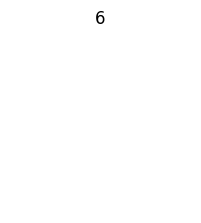

In [5]:
figure = plt.figure(figsize=(8, 8))
rows, column = 3, 3
for i in range(1, rows * column + 1):
    key, sample_key = random.split(key)
    sample_idx = int(random.randint(sample_key, shape=(1,), minval=0, maxval=len(training_dataset))[0])
    img: Image.Image
    label: str
    (img, label) = training_dataset[sample_idx]
    figure.add_subplot(rows, column, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [6]:
trainloader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
_x, _y = next(iter(trainloader))
_x, _y = _x.numpy(), _y.numpy()
print(f"x.shape: {_x.shape}")
print(f"y.shape: {_y.shape}")
print(f"y values: {set(map(int, set(_y)))}")

x.shape: (64, 784)
y.shape: (64,)
y values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [8]:
@jax.tree_util.register_pytree_node_class
class Model:
    def __init__(self, key: PRNGKeyArray):
        key1, key2, key3, key4 = random.split(key, 4)
        self.layers = [
            #Flatten(),
            Dense(28 * 28, 256, key=key1, activation=relu),
            Dense(256, 10, key=key4, activation=jax.nn.log_sigmoid),
        ]

    def __call__(self, x: Float[Array, "1 28 28"]) -> Float[Array, "10"]:
        for layer in self.layers:
            x = layer(x)
        return x

    def __repr__(self):
        return f"Model({self.layers})"

    def tree_flatten(self):
        return self.layers, None

    @classmethod
    def tree_unflatten(cls, _aux_data, children):
        del _aux_data
        model = cls.__new__(cls)
        model.layers = children
        return model

In [9]:
key, subkey = random.split(key)
model = Model(subkey)
model

Model([Dense(units=256, w.shape=(256, 784), b.shape=(256,), activation=<jax._src.custom_derivatives.custom_jvp object at 0x7f2c2015c1d0>), Dense(units=10, w.shape=(10, 256), b.shape=(10,), activation=<PjitFunction of <function log_sigmoid at 0x7f2c20162480>>)])

In [10]:
jax.tree.flatten(model)

([256,
  Array([[-0.9618722 , -0.39984876,  1.120765  , ...,  0.27563986,
           0.7467378 , -0.45333678],
         [-0.4979763 , -0.2562582 ,  0.94858146, ..., -0.6226083 ,
           1.4276365 ,  1.4007825 ],
         [ 1.2089579 , -0.31922126,  1.0280087 , ..., -1.5477383 ,
          -1.8612546 ,  1.1709294 ],
         ...,
         [ 0.12749602,  0.13316132,  0.45601392, ...,  3.125076  ,
           0.5163779 , -0.62032515],
         [-0.25030464, -0.4953383 , -1.4128605 , ...,  1.0755725 ,
          -1.0251373 ,  0.1451267 ],
         [-0.73438394, -0.6407877 ,  1.2557353 , ..., -2.0570147 ,
           1.9970965 ,  0.24062152]], dtype=float32),
  Array([ 1.1679052 , -0.57643586,  0.19118276, -0.13431379,  1.3862588 ,
         -1.0855845 , -0.29239202,  0.10064603,  0.24616094, -0.32994908,
         -0.78263813,  0.32451466, -0.48307243, -0.34692234,  0.7403934 ,
         -0.15749788,  1.1671768 ,  0.18472195,  0.93595326,  0.0617667 ,
         -0.36447927,  0.16116439, -0.3314

In [11]:
params, static = partition(model)
print(params)

Model((Dense(units=None, w.shape=(256, 784), activation=None), Dense(units=None, w.shape=(10, 256), activation=None)))


In [12]:
print(static)

Model((Dense(units=256, w.shape=None, b.shape=None, activation=<jax._src.custom_derivatives.custom_jvp object at 0x7f2c2015c1d0>), Dense(units=10, w.shape=None, b.shape=None, activation=<PjitFunction of <function log_sigmoid at 0x7f2c20162480>>)))


In [13]:
@partial(jit, static_argnames=("static",))
def loss(params: PyTree, static: PyTree, x: Float[Array, "batch 1 28 28"], y: Int[Array, "batch"]) -> FloatScalar:
    model = combine(params, static)
    y_pred = jax.vmap(model)(x)
    #return jnp.mean(softmax_cross_entropy(y_pred, y.reshape(-1, 1)))
    return optax.softmax_cross_entropy_with_integer_labels(y_pred, y).mean()


@partial(jit, static_argnames=("static",))
def accuracy(params: PyTree, static: PyTree, x: Float[Array, "batch 1 28 28"], y: Int[Array, "batch"]) -> FloatScalar:
    model = combine(params, static)
    y_pred = jax.vmap(model)(x)
    return jnp.mean(jnp.argmax(y_pred, axis=1) == y)


def evaluation(model: Model, testloader: DataLoader) -> tuple[FloatScalar, FloatScalar]:
    avg_loss = 0
    avg_accuarcy = 0
    params, static = partition(model)
    for x, y in testloader:
        x, y = x.numpy(), y.numpy()
        avg_loss += loss(params, static, x, y)
        avg_accuarcy += accuracy(params, static, x, y)
    return avg_loss / len(testloader), avg_accuarcy / len(testloader)


In [14]:
loss(params, static, _x, _y, ), accuracy(params, static,
                                         _x,
                                         _y)

(Array(83.72337, dtype=float32), Array(0.078125, dtype=float32))

In [15]:
value, grad = jax.value_and_grad(loss)(params, static, _x, _y)
print(value)
print(grad.layers[1].w)

83.72337
[[-7.8954983e-01  0.0000000e+00  6.9736824e-03 ... -2.9556367e-01
   8.0942882e-05 -7.8295775e-02]
 [ 1.5044270e-06  5.1989663e-12  3.9157936e-18 ...  5.0577629e-11
   7.7321614e-15  7.9996676e-09]
 [ 7.4194395e-06  2.2107329e-36  8.8996172e-36 ...  0.0000000e+00
   6.4833330e-07  7.5950578e-05]
 ...
 [ 4.4405460e-03  2.4399426e-30 -5.8471680e-02 ...  8.5309148e-04
   1.6260903e-03 -9.9540591e-02]
 [-1.8597357e-01  1.3075786e-10 -3.7573242e-01 ... -1.2438254e-02
   4.6222845e-10 -4.5825195e-01]
 [-5.4486084e-01 -6.1798096e-03 -7.9939216e-01 ... -3.3734056e-01
  -1.0472412e+00 -7.8468508e-01]]


In [16]:
optimizer = optax.adam(LEARNING_RATE)
train_history = []
test_history = []


@partial(jit, static_argnames=("static",))
def train_step(params: PyTree, static: PyTree, opt_state: PyTree, x: Float[Array, "batch 1 28 28"],
               y: Int[Array, "batch"]
               ) -> tuple[PyTree, PyTree, FloatScalar]:
    #jax.debug.print("train_step_start: {}", params.layers[1].w)
    value, grad = jax.value_and_grad(loss)(params, static, x, y)
    #jax.debug.print("grad: {}", grad.layers[1].w)
    updates, opt_state = optimizer.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    #jax.debug.print("{}", params.layers[1].w)
    return params, opt_state, value


def infinite_dataloader(loader):
    while True:
        yield from loader


def train(model: Model, trainloader: DataLoader, testloader: DataLoader, epoch: int, interval: int) -> Model:
    params, static = partition(model)
    print(params.layers[1].w)
    opt_state = optimizer.init(params)
    for epoch, (x, y) in zip(range(epoch), infinite_dataloader(trainloader)):

        x, y = x.numpy(), y.numpy()
        params, opt_state, loss_value = train_step(params, static, opt_state, x,
                                                   y)
        if epoch % interval == 0:
            avg_loss, avg_acc = evaluation(combine(params, static), testloader)
            print(f"Epoch: {epoch}, Loss: {avg_loss}, Accuracy: {avg_acc}")
            train_history.append(loss_value)
            test_history.append(evaluation(combine(params, static), testloader)[0])
    return combine(params, static)

TypeError: Invalid shape (784,) for image data

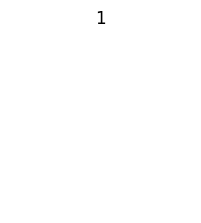

In [17]:
figure = plt.figure(figsize=(8, 8))
rows, column = 3, 3
for i in range(1, rows * column + 1):
    key, sample_key = random.split(key)
    sample_idx = int(random.randint(sample_key, shape=(1,), minval=0, maxval=len(training_dataset))[0])
    img: Image.Image
    label: str
    (img, label) = training_dataset[sample_idx]
    figure.add_subplot(rows, column, i)
    plt.title(str(jnp.argmax(model(jnp.array(img)))))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

plt.show()

In [18]:
print(params.layers[0])
model = train(model, trainloader, testloader, EPOCHES, PRINT_INTERVAL)
print(model.layers[1])

Dense(units=None, w.shape=(256, 784), activation=None)
[[ 0.31841344 -0.28364566  0.93150246 ...  0.6423392  -0.84715605
   1.3805236 ]
 [-0.06245933 -2.503396   -0.38665345 ... -1.3413899   0.08784661
   0.71105254]
 [-0.21208242  0.91559064  0.04708415 ... -0.47722173 -0.23170084
  -1.0912762 ]
 ...
 [-0.10328253  1.500601    0.91901124 ... -2.863092    1.2168186
   0.36090964]
 [-0.25708923 -1.0512546   0.7534251  ... -1.8426236  -1.636679
   0.6932188 ]
 [ 0.18459518 -1.4920831  -0.26703048 ...  0.5660823  -0.3408005
  -1.3818976 ]]
Epoch: 0, Loss: 68.52972412109375, Accuracy: 0.06409236043691635
Epoch: 30, Loss: 43.55037307739258, Accuracy: 0.05573248490691185
Epoch: 60, Loss: 25.328344345092773, Accuracy: 0.05394108220934868
Epoch: 90, Loss: 14.92131233215332, Accuracy: 0.057026274502277374
Epoch: 120, Loss: 9.527460098266602, Accuracy: 0.06369426846504211
Epoch: 150, Loss: 6.787137508392334, Accuracy: 0.0666799396276474
Epoch: 180, Loss: 5.22666597366333, Accuracy: 0.07115843892

In [19]:
evaluation(model, testloader)

(Array(2.3909817, dtype=float32), Array(0.09424761, dtype=float32))

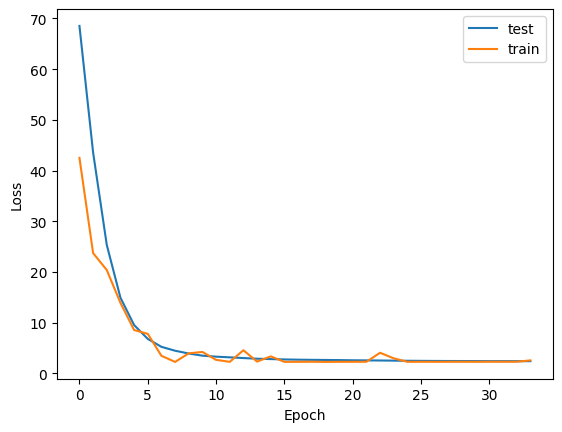

In [20]:
plt.plot(test_history, label="test")
plt.plot(train_history, label="train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [26]:
figure = plt.figure(figsize=(8, 8))
rows, column = 3, 3
for i in range(1, rows * column + 1):
    key, sample_key = random.split(key)
    sample_idx = int(random.randint(sample_key, shape=(1,), minval=0, maxval=len(training_dataset))[0])
    img: Image.Image
    label: str
    (img, label) = training_dataset[sample_idx]
    #figure.add_subplot(rows, column, i)
    print((model(jnp.array(img))))
    print(label)
    #plt.title(str(jnp.argmax(model(jnp.array(img)))))
    #plt.axis("off")
    #plt.imshow(img.squeeze(), cmap="gray")

plt.show()

[-0.0000e+00 -0.0000e+00 -0.0000e+00 -0.0000e+00 -0.0000e+00 -0.0000e+00
 -0.0000e+00 -0.0000e+00 -8.5406e-41 -0.0000e+00]
5
[-0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00
 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00
 -0.0000000e+00 -2.4663535e-37]
9
[-0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00
 -0.0000000e+00 -0.0000000e+00 -8.6142225e-17 -0.0000000e+00
 -0.0000000e+00 -0.0000000e+00]
9
[-0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
8
[-0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00
 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00
 -0.0000000e+00 -1.6814834e-11]
3
[-0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00
 -2.8325804e-21 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00
 -0.0000000e+00 -0.0000000e+00]
0
[-0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
9
[-0.000000e+00 -0.000000e+00 -0.000000e+00 -2.802597e-45 -0.000000e+00
 -0.000000e+00 -2.558708e-08 -0.000000e+00 -0.000000e+00 -0.000000e+00]
1
[-0.000000e+00 -0.

<Figure size 800x800 with 0 Axes>